In [1]:
import spym
import numpy as np
import pandas as pd
import numdifftools as nd
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

np.random.seed(42)
pd.set_option('display.max_columns', None)

In [2]:
# <1101> - potencjalna linia ilości punktów spektroskopii
# dI/dU__y - ilość krzywych spektroskopowych 
# <1076-7> - nazwa pliku
# <1986> - rozmiar obrazka w px,
# <1322> - roxmiar obrazka w nm, 
# <1833> - ON (backward), OFF  (forward)
file = spym.load('data/2023-03-17-0168.SM4')
file

<xarray.Dataset>
Dimensions:                (dI/dU__x: 346, dI/dU__y: 48, Current__x: 346,
                            Current__y: 48, dI/dU__Forward_x: 256,
                            dI/dU__Forward_y: 256, dI/dU__Backward_x: 256,
                            dI/dU__Backward_y: 256, Topography_Forward_x: 256,
                            Topography_Forward_y: 256,
                            Topography_Backward_x: 256,
                            Topography_Backward_y: 256)
Coordinates:
  * dI/dU__x               (dI/dU__x) float64 -2.001 -1.989 -1.977 ... 1.989 2.0
  * dI/dU__y               (dI/dU__y) uint32 0 1 2 3 4 5 6 ... 42 43 44 45 46 47
  * Current__x             (Current__x) float64 -2.001 -1.989 ... 1.989 2.0
  * Current__y             (Current__y) uint32 0 1 2 3 4 5 ... 42 43 44 45 46 47
  * dI/dU__Forward_x       (dI/dU__Forward_x) float64 0.0 ... 5.977e-09
  * dI/dU__Forward_y       (dI/dU__Forward_y) float64 0.0 ... 5.977e-09
  * dI/dU__Backward_x      (dI/dU__Backward_x) float64 0.0 ... 5.977e-09
  * dI/dU__Backward_y      (dI/dU__Backward_y) float64 0.0 ... 5.977e-09
  * Topography_Forward_x   (Topography_Forward_x) float64 0.0 ... 5.977e-09
  * Topography_Forward_y   (Topography_Forward_y) float64 0.0 ... 5.977e-09
  * Topography_Backward_x  (Topography_Backward_x) float64 0.0 ... 5.977e-09
  * Topography_Backward_y  (Topography_Backward_y) float64 0.0 ... 5.977e-09
Data variables:
    dI/dU_                 (dI/dU__x, dI/dU__y) float64 0.1309 0.127 ... 0.0354
    Current_               (Current__x, Current__y) float64 -6.5e-11 ... 6.28...
    dI/dU__Forward         (dI/dU__Forward_x, dI/dU__Forward_y) float64 -1.04...
    dI/dU__Backward        (dI/dU__Backward_x, dI/dU__Backward_y) float64 -1....
    Topography_Forward     (Topography_Forward_x, Topography_Forward_y) float64 ...
    Topography_Backward    (Topography_Backward_x, Topography_Backward_y) float64 ...

In [3]:
dIdU = file['Current_']
dIdU

<xarray.DataArray 'Current_' (Current__x: 346, Current__y: 48)>
array([[-6.50024410e-11, -6.13403317e-11, -1.24511718e-10, ...,
        -5.18798825e-11, -1.21459960e-10, -9.73510736e-11],
       [-7.84301753e-11, -8.27026362e-11, -1.58691405e-10, ...,
        -8.51440425e-11, -9.06372065e-11, -9.42993158e-11],
       [-1.07116699e-10, -1.07727050e-10, -1.20239257e-10, ...,
        -7.75146480e-11, -7.84301753e-11, -5.70678707e-11],
       ...,
       [ 9.64355463e-11,  9.91821283e-11,  1.43432616e-10, ...,
         4.88281247e-11,  1.43432616e-11,  1.77001952e-11],
       [ 1.13220214e-10,  7.35473628e-11,  1.37329101e-10, ...,
         8.54492182e-12,  4.21142576e-11,  2.47192381e-11],
       [ 7.47680660e-11,  7.47680660e-11,  1.40686034e-10, ...,
         4.57763669e-11,  6.28662106e-11,  6.28662106e-11]])
Coordinates:
  * Current__x  (Current__x) float64 -2.001 -1.989 -1.977 ... 1.977 1.989 2.0
  * Current__y  (Current__y) uint32 0 1 2 3 4 5 6 7 ... 40 41 42 43 44 45 46 47
Attributes: (12/81)
    RHK_PRMdata:                           WinSpm 2003.00 Program Configurati...
    RHK_PageID:                         6572
    RHK_PageDataType:                   1
    RHK_PageDataTypeName:               RHK_DATA_LINE
    RHK_PageSourceType:                 0
    RHK_PageSourceTypeName:             RHK_SOURCE_RAW
    ...                                 ...
    setpoint_units:                     
    feedback_active:                    None
    feedback_pgain:                     0
    scan_angle:                         0.0
    time_per_point:                     1e-05
    filename:                           2023-03-17-0168.SM4

In [4]:
# nazwa pliku
dIdU.attrs['filename']

'2023-03-17-0168.SM4'

In [5]:
# rozmiar w px
tf = file['Topography_Forward']
tf.shape

(256, 256)

In [6]:
# rozmiar w nm
idx = dIdU.attrs['RHK_PRMdata'].find('<1322>')
dIdU.attrs['RHK_PRMdata'][idx+19:idx+32]

'6.0000e-009 m'

In [7]:
# forward czy backward
idx = dIdU.attrs['RHK_PRMdata'].find('<1833>')
f_or_b = True if dIdU.attrs['RHK_PRMdata'][idx+34:idx+36] == 'ON' else False
f_or_b

True

In [8]:
# oś X
dIdU.coords['Current__x'].values

array([-2.00050354, -1.98890686, -1.97731018, -1.9657135 , -1.95411682,
       -1.94252014, -1.93092346, -1.91932678, -1.9077301 , -1.89613342,
       -1.88453674, -1.87294006, -1.86134338, -1.8497467 , -1.83815002,
       -1.82655334, -1.81495667, -1.80335999, -1.79176331, -1.78016663,
       -1.76856995, -1.75697327, -1.74537659, -1.73377991, -1.72218323,
       -1.71058655, -1.69898987, -1.68739319, -1.67579651, -1.66419983,
       -1.65260315, -1.64100647, -1.62940979, -1.61781311, -1.60621643,
       -1.59461975, -1.58302307, -1.57142639, -1.55982971, -1.54823303,
       -1.53663635, -1.52503967, -1.51344299, -1.50184631, -1.49024963,
       -1.47865295, -1.46705627, -1.45545959, -1.44386292, -1.43226624,
       -1.42066956, -1.40907288, -1.3974762 , -1.38587952, -1.37428284,
       -1.36268616, -1.35108948, -1.3394928 , -1.32789612, -1.31629944,
       -1.30470276, -1.29310608, -1.2815094 , -1.26991272, -1.25831604,
       -1.24671936, -1.23512268, -1.223526  , -1.21192932, -1.20

In [9]:
# oś Y
dIdU.values[:, 0]

array([-6.50024410e-11, -7.84301753e-11, -1.07116699e-10, -1.02233886e-10,
       -6.16455074e-11, -8.78906245e-11, -1.07421874e-10, -8.45336909e-11,
       -4.51660154e-11, -7.56835933e-11, -9.91821283e-11, -7.20214839e-11,
       -5.15747067e-11, -7.20214839e-11, -9.00268549e-11, -5.64575192e-11,
       -4.73022458e-11, -8.30078120e-11, -8.66699213e-11, -5.58471676e-11,
       -4.60815427e-11, -8.51440425e-11, -7.90405269e-11, -4.24194333e-11,
       -5.03540036e-11, -9.46044916e-11, -6.86645504e-11, -3.05175779e-11,
       -4.69970700e-11, -7.72094722e-11, -5.55419918e-11, -3.99780271e-11,
       -6.04248043e-11, -7.96508784e-11, -4.51660154e-11, -2.86865233e-11,
       -6.46972652e-11, -6.89697261e-11, -2.99072264e-11, -3.23486326e-11,
       -6.95800777e-11, -6.10351559e-11, -1.64794921e-11, -2.31933592e-11,
       -6.31713863e-11, -5.61523434e-11, -2.34985350e-11, -4.15039060e-11,
       -6.37817379e-11, -4.08935544e-11, -1.22070312e-11, -4.39453122e-11,
       -6.07299801e-11, -

In [10]:
# tworzenie obiektu df
dataset = pd.DataFrame(dIdU.values, columns=[f'y{x}' for x in range(dIdU.coords['Current__y'].size)])
dataset['x'] = dIdU.coords['Current__x']

# przeszukiwanie metadanych w poszukiwaniu informacji ile krzywych zrobiono w jednym punkcie
idx = dIdU.attrs['RHK_PRMdata'].find('<1101>')
curves_per_point = int(dIdU.attrs['RHK_PRMdata'][idx+28:idx+29])

# wyznaczanie ilości krzywych i punktów pomiarowych
num_of_curves = dIdU.coords['Current__y'].size
num_of_points = num_of_curves // curves_per_point

# tworzenie przedziałów punktowych
intervals = np.linspace(0, num_of_curves, num_of_points+1, dtype=int)

# warunek sprawdzający od jakiego kierunku zaczynał się pomiar spektroskopii, True = forward, False = backward
direction = True
i = 1 if direction else -1

for idx in range(len(intervals) - 1):
    for fb, name in enumerate(['forward', 'backward'][::i]):
        start = fb + intervals[idx]
        stop = intervals[idx+1]
        columns = dataset.columns[start:stop:2]
        dataset[f'mean_{name}_p{idx+1}'] = dataset[columns].mean(axis=1)
        
for idx in range(len(intervals)-1):
    start = intervals[idx]
    stop = intervals[idx+1]
    columns = dataset.columns[start:stop]
    dataset[f'mean_p{idx+1}'] = dataset[columns].mean(axis=1)

        
for fb, name in enumerate(['forward', 'backward'][::i]):
    start = fb + num_of_curves+1
    stop = fb + num_of_curves+1 + num_of_points*2
    columns = dataset.columns[start:stop:2]
    dataset[f'mean_{name}'] = dataset[columns].mean(axis=1)

dataset

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29,y30,y31,y32,y33,y34,y35,y36,y37,y38,y39,y40,y41,y42,y43,y44,y45,y46,y47,x,mean_forward_p1,mean_backward_p1,mean_forward_p2,mean_backward_p2,mean_forward_p3,mean_backward_p3,mean_forward_p4,mean_backward_p4,mean_forward_p5,mean_backward_p5,mean_forward_p6,mean_backward_p6,mean_forward_p7,mean_backward_p7,mean_forward_p8,mean_backward_p8,mean_p1,mean_p2,mean_p3,mean_p4,mean_p5,mean_p6,mean_p7,mean_p8,mean_forward,mean_backward
0,-6.500244e-11,-6.134033e-11,-1.245117e-10,-1.855469e-10,-8.148193e-11,-9.094238e-11,-7.110596e-11,-6.835937e-11,-1.220703e-10,-1.327515e-10,-8.453369e-11,-9.796143e-11,-1.080322e-10,-9.002685e-11,-7.415771e-11,-8.972168e-11,-8.850098e-11,-7.385254e-11,-5.889893e-11,-4.577637e-11,-1.193237e-10,-1.028442e-10,-6.500244e-11,-6.286621e-11,-8.941650e-11,-6.408691e-11,-1.184082e-10,-1.232910e-10,-7.690430e-11,-7.873535e-11,-8.605957e-11,-6.896973e-11,-1.287842e-10,-1.293945e-10,-7.019043e-11,-5.920410e-11,-1.226807e-10,-1.092529e-10,-5.645752e-11,-6.683350e-11,-1.214600e-10,-1.385498e-10,-1.129150e-10,-1.037598e-10,-8.392334e-11,-5.187988e-11,-1.214600e-10,-9.735107e-11,-2.000504,-9.033203e-11,-1.126099e-10,-9.256999e-11,-9.969075e-11,-9.023031e-11,-8.453369e-11,-8.107503e-11,-7.049561e-11,-9.490967e-11,-8.870443e-11,-9.501139e-11,-8.585612e-11,-1.001994e-10,-1.048787e-10,-1.060994e-10,-8.433024e-11,-1.014709e-10,-9.613037e-11,-8.738200e-11,-7.578532e-11,-9.180705e-11,-9.043376e-11,-1.025391e-10,-9.521484e-11,-9.380341e-11,-9.138743e-11
1,-7.843018e-11,-8.270264e-11,-1.586914e-10,-1.461792e-10,-5.889893e-11,-1.181030e-10,-9.063721e-11,-7.293701e-11,-1.162720e-10,-1.049805e-10,-1.354980e-10,-8.422852e-11,-8.209228e-11,-1.010132e-10,-9.643555e-11,-9.063721e-11,-7.629394e-11,-1.315308e-10,-8.819580e-11,-6.134033e-11,-1.034546e-10,-9.552002e-11,-7.446289e-11,-9.124756e-11,-6.195068e-11,-9.918213e-11,-7.629394e-11,-1.284790e-10,-9.490967e-11,-8.331299e-11,-7.141113e-11,-1.046753e-10,-1.058960e-10,-1.144409e-10,-7.537842e-11,-7.965088e-11,-1.016235e-10,-9.582519e-11,-8.422852e-11,-6.591797e-11,-1.181030e-10,-1.068115e-10,-1.107788e-10,-7.629394e-11,-5.523682e-11,-8.514404e-11,-9.063721e-11,-9.429932e-11,-1.988907,-9.867350e-11,-1.156616e-10,-1.141357e-10,-8.738200e-11,-8.494059e-11,-1.077271e-10,-8.870443e-11,-8.270264e-11,-7.771810e-11,-1.036580e-10,-8.422852e-11,-9.958903e-11,-1.013184e-10,-8.951823e-11,-8.555094e-11,-8.524577e-11,-1.071676e-10,-1.007589e-10,-9.633382e-11,-8.570353e-11,-9.068807e-11,-9.190877e-11,-9.541829e-11,-8.539836e-11,-9.190877e-11,-9.643555e-11
2,-1.071167e-10,-1.077271e-10,-1.202393e-10,-1.385498e-10,-9.826660e-11,-1.159668e-10,-1.046753e-10,-1.046753e-10,-7.720947e-11,-7.904053e-11,-1.281738e-10,-1.159668e-10,-6.347656e-11,-5.615234e-11,-1.211548e-10,-1.266479e-10,-1.062012e-10,-1.205444e-10,-1.165771e-10,-9.338379e-11,-7.873535e-11,-5.950928e-11,-1.116943e-10,-1.165771e-10,-8.697510e-11,-8.544922e-11,-7.019043e-11,-8.911133e-11,-1.202393e-10,-1.116943e-10,-1.022339e-10,-1.150513e-10,-7.720947e-11,-8.728027e-11,-1.046753e-10,-9.643555e-11,-5.950928e-11,-5.920410e-11,-1.202393e-10,-9.887695e-11,-8.209228e-11,-7.293701e-11,-6.591797e-11,-7.293701e-11,-8.361816e-11,-7.751465e-11,-7.843018e-11,-5.706787e-11,-1.977310,-1.085409e-10,-1.207479e-10,-1.033529e-10,-9.989421e-11,-9.694417e-11,-1.011149e-10,-1.023356e-10,-8.982340e-11,-9.246826e-11,-9.541829e-11,-9.470622e-11,-9.958903e-11,-8.728027e-11,-7.700602e-11,-7.598877e-11,-6.917318e-11,-1.146444e-10,-1.016235e-10,-9.902954e-11,-9.607951e-11,-9.394328e-11,-9.714762e-11,-8.214315e-11,-7.258097e-11,-9.520213e-11,-9.409587e-11
3,-1.022339e-10,-8.544922e-11,-8.453369e-11,-1.672363e-10,-1.171875e-10,-7.171631e-11,-7.781982e-11,-1.007080e-10,-1.065063e-10,-1.052856e-10,-9.429932e-11,-1.428223e-10,-1.080322e-10,-4.455566e-11,-9.429932e-11,-1.239014e-10,-1.092529e-10,-8.789062e-11,-8.605957e-11,-7.263184e-11,-8.178711e-11,-9.368896e-11,-1.083

mean_p1
mean_p2
mean_p3
mean_p4
mean_p5
mean_p6
mean_p7
mean_p8


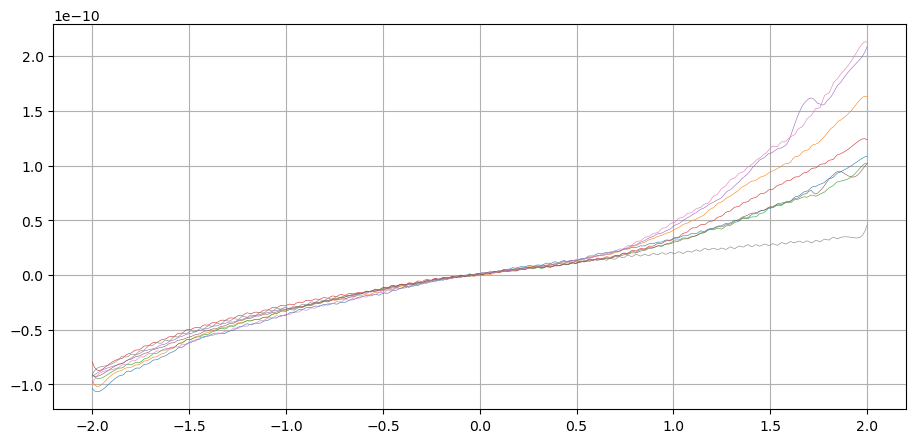

In [11]:
# tworzenie wykresów wszystkich krzywych
x = dataset['x']
y = dataset[dataset.columns[-num_of_points-2:-2]]
w_size = 25

plt.figure(figsize=(11,5))
for column in y.columns:
    print(column)
    y_smoothed = savgol_filter(dataset[column], w_size, 5)
    plt.plot(x, y_smoothed, label=column, linewidth=0.4)
plt.grid('On')
plt.show()

Text(0, 0.5, 'Number of curve')

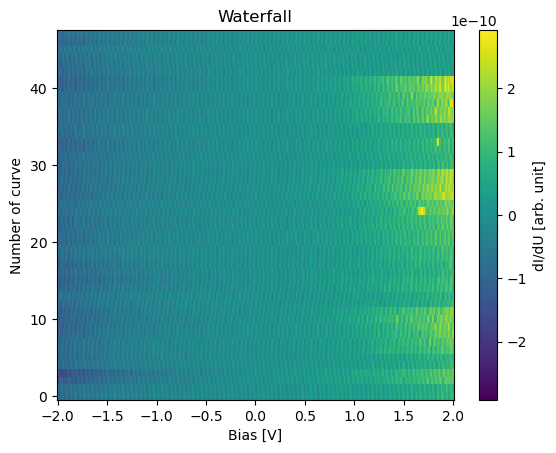

In [12]:
# na moje oko wygląda jak waterfall ale temat do dyskusji, głównie sam wygląd wykresu
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
dIdU.spym.plot(title='Waterfall', cmap='viridis', cbar_kwargs={'label': 'dI/dU [arb. unit]'})
plt.xlabel('Bias [V]')
plt.ylabel('Number of curve')

In [13]:
file.keys()

KeysView(<xarray.Dataset>
Dimensions:                (dI/dU__x: 346, dI/dU__y: 48, Current__x: 346,
                            Current__y: 48, dI/dU__Forward_x: 256,
                            dI/dU__Forward_y: 256, dI/dU__Backward_x: 256,
                            dI/dU__Backward_y: 256, Topography_Forward_x: 256,
                            Topography_Forward_y: 256,
                            Topography_Backward_x: 256,
                            Topography_Backward_y: 256)
Coordinates:
  * dI/dU__x               (dI/dU__x) float64 -2.001 -1.989 -1.977 ... 1.989 2.0
  * dI/dU__y               (dI/dU__y) uint32 0 1 2 3 4 5 6 ... 42 43 44 45 46 47
  * Current__x             (Current__x) float64 -2.001 -1.989 ... 1.989 2.0
  * Current__y             (Current__y) uint32 0 1 2 3 4 5 ... 42 43 44 45 46 47
  * dI/dU__Forward_x       (dI/dU__Forward_x) float64 0.0 ... 5.977e-09
  * dI/dU__Forward_y       (dI/dU__Forward_y) float64 0.0 ... 5.977e-09
  * dI/dU__Backward_x      (dI/dU__B

In [14]:
# wyświetlić nazwę pliku, datę, liczbę punktów, rozmiar obrazka, 

In [15]:
len('1986>	Scan X Size ::')

20

In [16]:
idx_x = file['dI/dU_'].attrs['RHK_PRMdata'].find('<1986>')
idx_x

16959

In [17]:
file['dI/dU_'].attrs['RHK_PRMdata'][idx_x+21:idx_x+24]

'256'

In [18]:
idx = file['dI/dU_'].attrs['RHK_PRMdata'].find('<1322>')
start = file['dI/dU_'].attrs['RHK_PRMdata'][idx:].find('::') + 2 + idx
stop = file['dI/dU_'].attrs['RHK_PRMdata'][idx:].find('\r') + idx

In [19]:
print(start, stop)

16944 16957


In [20]:
file['dI/dU_'].attrs['RHK_PRMdata'][start:stop]

'6.0000e-009 m'

In [21]:
idx = file['dI/dU_'].attrs['RHK_PRMdata'].find('<1833>')
start = file['dI/dU_'].attrs['RHK_PRMdata'][idx:].find('::') + 2 + idx
stop = file['dI/dU_'].attrs['RHK_PRMdata'][idx:].find('\r') + idx

file['dI/dU_'].attrs['RHK_PRMdata'][start:stop]

'ON'

[-2.26326282e-13  2.13120481e-13  1.92523705e-12 -1.85059689e-12
 -4.83662400e-12  5.68134017e-12  9.41731378e-12 -6.70541616e-12
  2.84932930e-11  1.01401694e-12]


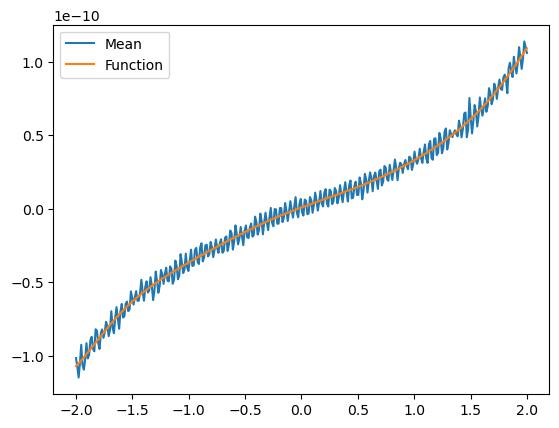

In [41]:
x = dataset['x'].values
y = dataset['mean_p1'].values
_ = plt.plot(x, y, label='Mean')

y_poli = np.polyfit(x, y, deg=9)
print(y_poli)
f = np.poly1d(y_poli)
_ = plt.plot(x, f(x), label='Function')
plt.legend()

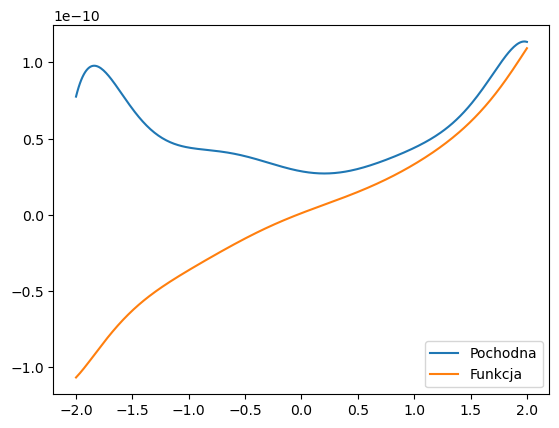

In [42]:
div = nd.Derivative(f, n=1)
#plt.plot(x,y)
plt.plot(x, div(x), label='Pochodna')
plt.plot(x,f(x), label='Funkcja')
plt.legend()

In [24]:
#Operacje matematyczne na krzywych (dodawanie i uśrednianie)
#Wybór wyświetlanych krzywych

In [25]:
start = curves_per_point*num_of_points + 2*num_of_points+1
dataset_mean = dataset.iloc[:, start:-2]
dataset_mean

,mean_p1,mean_p2,mean_p3,mean_p4,mean_p5,mean_p6,mean_p7,mean_p8
0,-1.014709e-10,-9.613037e-11,-8.738200e-11,-7.578532e-11,-9.180705e-11,-9.043376e-11,-1.025391e-10,-9.521484e-11
1,-1.071676e-10,-1.007589e-10,-9.633382e-11,-8.570353e-11,-9.068807e-11,-9.190877e-11,-9.541829e-11,-8.539836e-11
2,-1.146444e-10,-1.016235e-10,-9.902954e-11,-9.607951e-11,-9.394328e-11,-9.714762e-11,-8.214315e-11,-7.258097e-11
3,-1.047262e-10,-1.045736e-10,-9.465535e-11,-8.804321e-11,-8.967082e-11,-9.379069e-11,-8.911133e-11,-8.677165e-11
4,-9.241740e-11,-9.648641e-11,-8.438110e-11,-7.700602e-11,-8.402506e-11,-8.819580e-11,-1.013184e-10,-9.735107e-11
...,...,...,...,...,...,...,...,...
341,9.526571e-11,1.641846e-10,8.514404e-11,1.125081e-10,1.873271e-10,9.094238e-11,2.073669e-10,4.608154e-11
342,1.025391e-10,1.553853e-10,9.679158e-11,1.186625e-10,1.931254e-10,9.338379e-11,2.129110e-10,4.114787e-11
343,1.139323e-10,1.592509e-10,1.115417e-10,1.320902e-10,2.049255e-10,9.994507e-11,2.127584e-10,2.812703e-11
344,1.100159e-10,1.688131e-10,9.938558e-11,1.291911e-10,2.021790e-10,9.511312e-11,2.183024e-10,3.392537e-11


<h1>Test</h1>

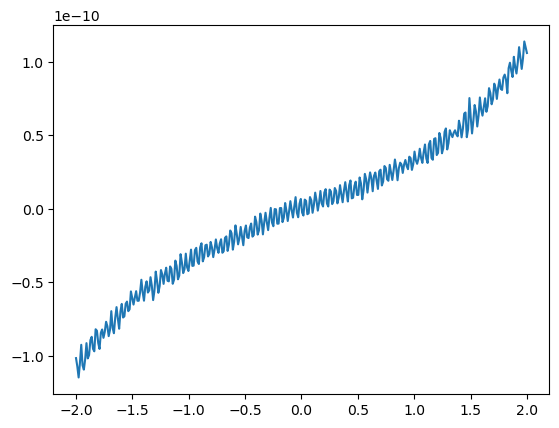

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

# Przykładowe dane
X_train = dataset['x'].values
X_train = X_train.reshape((-1,1))
y_train = dataset['mean_p1'].values

plt.plot(x_dane, y_dane)


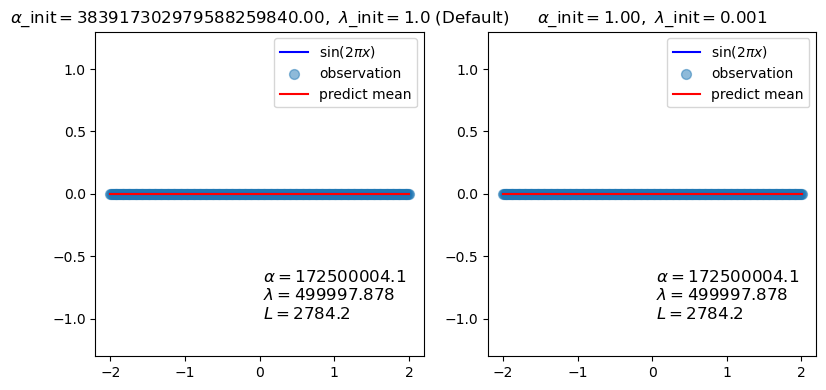

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.0]  # Default values
    elif i == 1:
        init = [1.0, 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)

    ax.plot(X_train, y_train, color="blue", label="sin($2\\pi x$)")
    ax.scatter(X_train, y_train, s=50, alpha=0.5, label="observation")
    ax.plot(X_train, y_train, color="red", label="predict mean")

    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
        reg.alpha_, reg.lambda_, reg.scores_[-1]
    )
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()